# TPU approach

I'm learning to use TPUs (see https://www.kaggle.com/code/ryanholbrook/getting-started-with-tpus), so this is my attempt for this competition.

**Note** TPU is not currently working, I've asked in the forums https://www.kaggle.com/discussions/questions-and-answers/582296 . The notebook will also run on CPU or GPU, without any code changes.

The model itself is a simple neural network in keras - I am focusing more on using TPUs than the actual competition.

In [1]:
!pip install -q polars

In [2]:
import math, re, os
import tensorflow as tf
import numpy as np
import polars as pl
from matplotlib import pyplot as plt
#from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.preprocessing import LabelEncoder
import kaggle_evaluation.cmi_inference_server


2025-06-26 12:55:48.911978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750942549.138677      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750942549.200226      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# copy&paste from https://www.kaggle.com/code/ryanholbrook/getting-started-with-tpus
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None
    print("not running on TPU")

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Tensorflow version 2.18.0
not running on TPU
REPLICAS:  1


In [4]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## Read Data

In [5]:
# Load data
train_df = pd.read_csv("/kaggle/input/cmi-detect-behavior-with-sensor-data/train.csv")
targets = train_df[['sequence_id', 'gesture']].drop_duplicates()


In [6]:
train_df.head()

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,-1.0,-1.0,112.0,119.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,-1.0,-1.0,101.0,111.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,-1.0,-1.0,101.0,109.0,125.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [7]:
train_demographics = pd.read_csv("/kaggle/input/cmi-detect-behavior-with-sensor-data/train_demographics.csv")
train_demographics.head()

,subject,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SUBJ_000206,1,41,1,1,172.0,50,25.0
1,SUBJ_001430,0,11,0,1,167.0,51,27.0
2,SUBJ_002923,1,28,1,0,164.0,54,26.0
3,SUBJ_003328,1,33,1,1,171.0,52,25.0
4,SUBJ_004117,0,15,0,1,184.0,54,28.0


### Merge all in one dataset

There may be smarter way to do this merge, but for now, let's put it all together.

In [8]:
train_df = train_df.merge(train_demographics, on='subject', how='left')
train_df.fillna(method='ffill', inplace=True)

/tmp/ipykernel_20/234058094.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df.fillna(method='ffill', inplace=True)


In [9]:
train_df.head()

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_5_v61,tof_5_v62,tof_5_v63,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0


In [10]:
train_df.describe()


,sequence_counter,acc_x,acc_y,acc_z,rot_w,rot_x,rot_y,rot_z,thm_1,thm_2,...,tof_5_v61,tof_5_v62,tof_5_v63,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
count,574945.000000,574945.000000,574945.000000,574945.000000,574945.000000,574945.000000,574945.000000,574945.000000,574945.000000,574945.000000,...,574945.000000,574945.000000,574945.000000,574945.000000,574945.000000,574945.000000,574945.000000,574945.000000,574945.000000,574945.000000
mean,43.645234,1.639980,1.790704,-0.459811,0.359589,-0.119262,-0.059807,-0.187373,27.086830,27.142138,...,31.747475,28.780502,27.129085,0.504544,21.630276,0.600247,0.875898,167.647967,51.502566,25.418165
std,45.717673,5.781259,5.003945,6.096490,0.225530,0.466052,0.543588,0.504215,3.226488,2.943012,...,60.412848,57.104146,55.324165,0.499980,10.343351,0.489848,0.329699,10.740996,4.900248,2.964853
min,0.000000,-34.585938,-24.402344,-42.855469,0.000000,-0.999146,-0.999695,-0.998169,-0.370413,21.958820,...,-1.000000,-1.000000,-1.000000,0.000000,10.000000,0.000000,0.000000,135.000000,41.000000,18.000000
25%,17.000000,-2.964844,-2.121094,-5.417969,0.179443,-0.456421,-0.512878,-0.626587,24.764328,24.545063,...,-1.000000,-1.000000,-1.000000,0.000000,13.000000,0.000000,1.000000,163.000000,49.000000,24.000000
50%,35.000000,2.972656,0.695312,-1.562500,0.339417,-0.186523,-0.112671,-0.263000,26.992983,26.372349,...,-1.000000,-1.000000,-1.000000,1.000000,20.000000,1.000000,1.000000,170.000000,52.000000,25.000000
75%,54.000000,6.343750,6.816406,5.164062,0.502502,0.205933,0.442993,0.252930,29.431932,29.631985,...,41.000000,34.000000,29.000000,1.000000,27.000000,1.000000,1.000000,174.000000,55.000000,27.000000
max,699.000000,46.328125,27.183594,30.078125,0.999390,0.999817,0.999451,0.999878,38.457664,37.578339,...,249.000000,249.000000,249.000000,1.000000,53.000000,1.000000,1.000000,190.500000,71.000000,44.000000


In [11]:
', '.join(train_df.columns.to_list())

'row_id, sequence_type, sequence_id, sequence_counter, subject, orientation, behavior, phase, gesture, acc_x, acc_y, acc_z, rot_w, rot_x, rot_y, rot_z, thm_1, thm_2, thm_3, thm_4, thm_5, tof_1_v0, tof_1_v1, tof_1_v2, tof_1_v3, tof_1_v4, tof_1_v5, tof_1_v6, tof_1_v7, tof_1_v8, tof_1_v9, tof_1_v10, tof_1_v11, tof_1_v12, tof_1_v13, tof_1_v14, tof_1_v15, tof_1_v16, tof_1_v17, tof_1_v18, tof_1_v19, tof_1_v20, tof_1_v21, tof_1_v22, tof_1_v23, tof_1_v24, tof_1_v25, tof_1_v26, tof_1_v27, tof_1_v28, tof_1_v29, tof_1_v30, tof_1_v31, tof_1_v32, tof_1_v33, tof_1_v34, tof_1_v35, tof_1_v36, tof_1_v37, tof_1_v38, tof_1_v39, tof_1_v40, tof_1_v41, tof_1_v42, tof_1_v43, tof_1_v44, tof_1_v45, tof_1_v46, tof_1_v47, tof_1_v48, tof_1_v49, tof_1_v50, tof_1_v51, tof_1_v52, tof_1_v53, tof_1_v54, tof_1_v55, tof_1_v56, tof_1_v57, tof_1_v58, tof_1_v59, tof_1_v60, tof_1_v61, tof_1_v62, tof_1_v63, tof_2_v0, tof_2_v1, tof_2_v2, tof_2_v3, tof_2_v4, tof_2_v5, tof_2_v6, tof_2_v7, tof_2_v8, tof_2_v9, tof_2_v10, tof_2_v1

## Prepare Targets and Feature Selection

We only use a few features for now, to simplify the model.

In [12]:

# Encode gesture labels
label_encoder = LabelEncoder()
targets['gesture_enc'] = label_encoder.fit_transform(targets['gesture'])
gesture2id = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Features to use (IMU only)
FEATURES = [
    'acc_x', 'acc_y', 'acc_z',
    'rot_w', 'rot_x', 'rot_y', 'rot_z'
]



In [13]:

# Feature selection
IMU_FEATURES = ['acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z']
THERMO_FEATURES = [f'thm_{i}' for i in range(1, 6)]
TOF_FEATURES = [f'tof_{i}_v{j}' for i in range(1, 6) for j in range(64)]
DEMO_FEATURES = ['adult_child', 'age', 'sex', 'handedness', 'height_cm', 'shoulder_to_wrist_cm', 'elbow_to_wrist_cm']

FEATURES = IMU_FEATURES + THERMO_FEATURES + DEMO_FEATURES  + TOF_FEATURES # TOF excluded for now due to sparsity

In [14]:
FEATURES

['acc_x',
 'acc_y',
 'acc_z',
 'rot_w',
 'rot_x',
 'rot_y',
 'rot_z',
 'thm_1',
 'thm_2',
 'thm_3',
 'thm_4',
 'thm_5',
 'adult_child',
 'age',
 'sex',
 'handedness',
 'height_cm',
 'shoulder_to_wrist_cm',
 'elbow_to_wrist_cm',
 'tof_1_v0',
 'tof_1_v1',
 'tof_1_v2',
 'tof_1_v3',
 'tof_1_v4',
 'tof_1_v5',
 'tof_1_v6',
 'tof_1_v7',
 'tof_1_v8',
 'tof_1_v9',
 'tof_1_v10',
 'tof_1_v11',
 'tof_1_v12',
 'tof_1_v13',
 'tof_1_v14',
 'tof_1_v15',
 'tof_1_v16',
 'tof_1_v17',
 'tof_1_v18',
 'tof_1_v19',
 'tof_1_v20',
 'tof_1_v21',
 'tof_1_v22',
 'tof_1_v23',
 'tof_1_v24',
 'tof_1_v25',
 'tof_1_v26',
 'tof_1_v27',
 'tof_1_v28',
 'tof_1_v29',
 'tof_1_v30',
 'tof_1_v31',
 'tof_1_v32',
 'tof_1_v33',
 'tof_1_v34',
 'tof_1_v35',
 'tof_1_v36',
 'tof_1_v37',
 'tof_1_v38',
 'tof_1_v39',
 'tof_1_v40',
 'tof_1_v41',
 'tof_1_v42',
 'tof_1_v43',
 'tof_1_v44',
 'tof_1_v45',
 'tof_1_v46',
 'tof_1_v47',
 'tof_1_v48',
 'tof_1_v49',
 'tof_1_v50',
 'tof_1_v51',
 'tof_1_v52',
 'tof_1_v53',
 'tof_1_v54',
 'tof_1_v55'

## Prepare Sequences

In [15]:
# Prepare sequences
sequence_ids = train_df['sequence_id'].unique()
X, y = [], []
for seq_id in sequence_ids:
    df = train_df[train_df['sequence_id'] == seq_id]
    if df[FEATURES].isnull().values.any():
        continue  # skip incomplete sequences
    x = df[FEATURES].values.astype(np.float32)
    if x.shape[0] < 64:
        pad_width = 64 - x.shape[0]
        x = np.pad(x, ((0, pad_width), (0, 0)), mode='edge')
    else:
        x = x[:64]
    X.append(x)
    y.append(targets.loc[targets['sequence_id'] == seq_id, 'gesture_enc'].values[0])

X = np.stack(X)
y = np.array(y)

In [16]:
# Train/Val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
BATCH_SIZE = 64 * strategy.num_replicas_in_sync

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1024).batch(BATCH_SIZE).prefetch(AUTO)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(AUTO)

I0000 00:00:1750942945.813947      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750942945.814694      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## Build TPU model

Apparently Keras is easier for developing TPU models.

In [17]:
# Build model with TPU strategy
with strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(64, len(FEATURES))),
        tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu'),
        tf.keras.layers.Conv1D(128, 5, padding='same', activation='relu'),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

model

<Sequential name=sequential, built=True>

## Train!

TODO: implement cross-validation in TPUs

In [18]:
# Train
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_class_output_loss',
    patience=5,
    restore_best_weights=True, mode="min"
)

history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stop])



Epoch 1/50


I0000 00:00:1750942951.183897      68 service.cc:148] XLA service 0x78d84000a6f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750942951.184956      68 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750942951.184976      68 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750942951.445391      68 cuda_dnn.cc:529] Loaded cuDNN version 90300


 31/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0838 - loss: 27.6554

I0000 00:00:1750942954.172054      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.0975 - loss: 12.6301 - val_accuracy: 0.1042 - val_loss: 2.6776
Epoch 2/50
 34/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1408 - loss: 2.6042

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_class_output_loss` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1439 - loss: 2.5863 - val_accuracy: 0.1654 - val_loss: 2.5398
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1981 - loss: 2.4047 - val_accuracy: 0.1838 - val_loss: 2.4000
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2594 - loss: 2.2117 - val_accuracy: 0.2414 - val_loss: 2.2670
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2942 - loss: 2.0707 - val_accuracy: 0.2684 - val_loss: 2.1748
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3408 - loss: 1.9413 - val_accuracy: 0.2953 - val_loss: 2.1747
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3600 - loss: 1.8940 - val_accuracy: 0.3125 - val_loss: 2.1248
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3961 - loss: 1.7700 - val_accuracy: 0.3223 - val_loss: 2.0733
Epoch 9/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4148 - loss: 1.7030 - val_accuracy: 0.3309 - val_

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Validation Classification Report:
                                            precision    recall  f1-score   support

                     Above ear - pull hair       0.46      0.41      0.43        64
                        Cheek - pinch skin       0.33      0.22      0.26        64
                     Drink from bottle/cup       0.41      0.81      0.54        16
                       Eyebrow - pull hair       0.19      0.22      0.21        64
                       Eyelash - pull hair       0.28      0.34      0.31        64
Feel around in tray and pull out an object       0.70      0.44      0.54        16
                  Forehead - pull hairline       0.39      0.42      0.40        64
                        Forehead - scratch       0.28      0.17      0.21        64
                            Glasses on/off       0.90      0.56      0.69        16
                         Neck - pinch skin       0.17      0.16      0.16        64
 

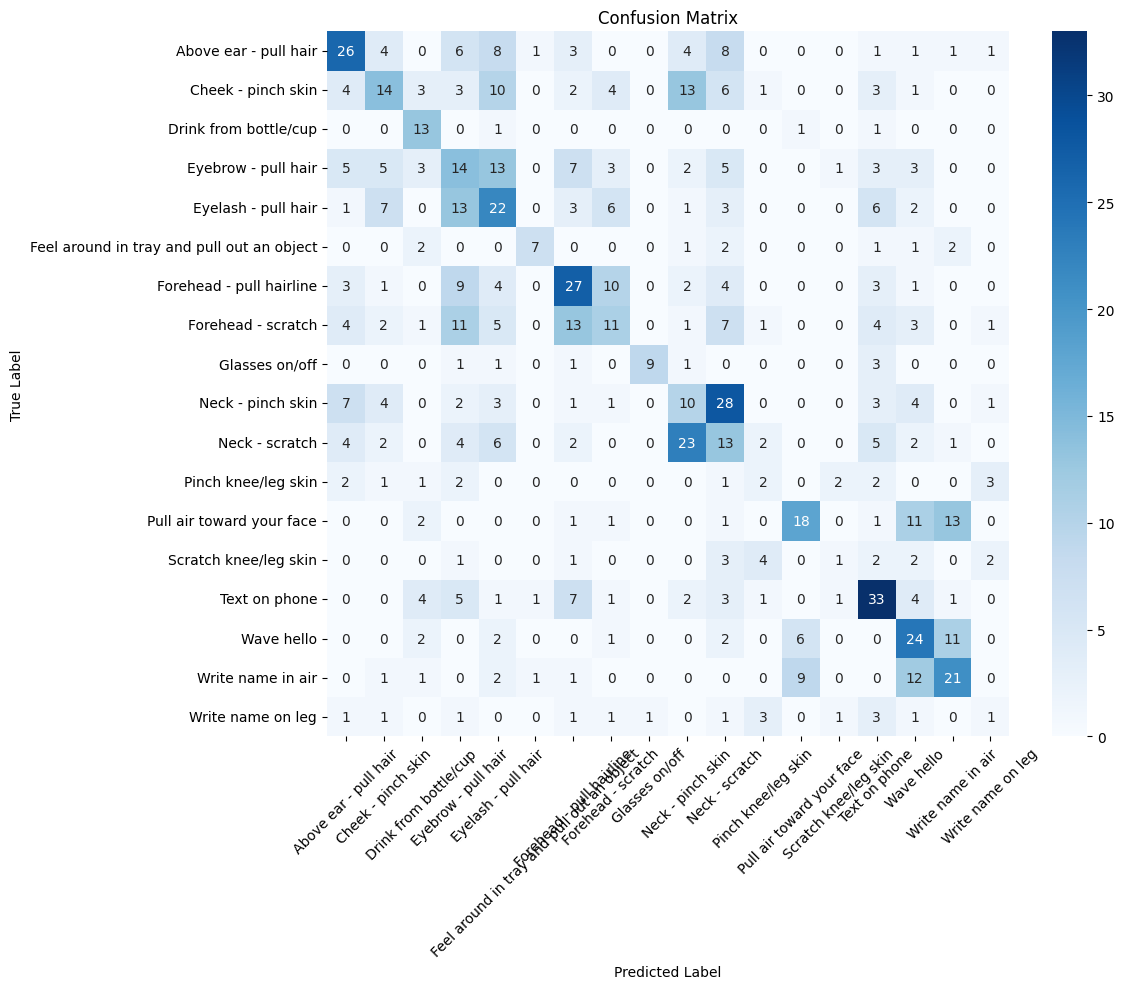

Binary F1: 1.0000, Macro F1: 0.3323, Final Score: 0.6662
Binary F1: 1.0000, Macro F1: 0.3323, Final Score: 0.6662


In [19]:
# Evaluate model
val_preds = model.predict(val_ds)
y_val_pred = np.argmax(val_preds, axis=1)

from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

binary_true = np.isin(y_val, [label_encoder.transform([g])[0] for g in label_encoder.classes_ if g != 'non_target']).astype(int)
binary_pred = np.isin(y_val_pred, [label_encoder.transform([g])[0] for g in label_encoder.classes_ if g != 'non_target']).astype(int)

binary_f1 = f1_score(binary_true, binary_pred)
macro_f1 = f1_score(y_val, y_val_pred, average='macro')
final_score = 0.5 * (binary_f1 + macro_f1)

print(f"Binary F1: {binary_f1:.4f}, Macro F1: {macro_f1:.4f}, Final Score: {final_score:.4f}")

print(f"Binary F1: {binary_f1:.4f}, Macro F1: {macro_f1:.4f}, Final Score: {final_score:.4f}")

In [20]:
#model.save("./model")
#pd.Series(label_encoder.classes_).to_csv("gesture_labels.csv", index=False)


## Create Submission Interface

In [21]:
# Inference function for the evaluation API
def predict(sequence, demographics) -> str:
    sequence = sequence.to_pandas()
    demographics = demographics.to_pandas()
    df = pd.merge(sequence, demographics, on='subject', how='left')

    df.fillna(method='ffill', inplace=True)
    x = df[FEATURES].values.astype(np.float32)
    if x.shape[0] < 64:
        pad_width = 64 - x.shape[0]
        x = np.pad(x, ((0, pad_width), (0, 0)), mode='edge')
    else:
        x = x[:64]
    x = np.expand_dims(x, axis=0)
    probs = model.predict(x, verbose=0)[0]
    pred_idx = np.argmax(probs)
    return label_encoder.inverse_transform([pred_idx])[0]

# Launch evaluation server
inference_server = kaggle_evaluation.cmi_inference_server.CMIInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        data_paths=(
            '/kaggle/input/cmi-detect-behavior-with-sensor-data/test.csv',
            '/kaggle/input/cmi-detect-behavior-with-sensor-data/test_demographics.csv',
        )
    )

/tmp/ipykernel_20/1800914401.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipykernel_20/1800914401.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
